# ViT Grad Rollout

In [2]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

def grad_rollout(attentions, gradients, discard_ratio):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention, grad in zip(attentions, gradients):                
            weights = grad
            attention_heads_fused = (attention*weights).mean(axis=1)
            attention_heads_fused[attention_heads_fused < 0] = 0

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            #indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionGradRollout:
    def __init__(self, model, attention_layer_name='attn_drop',
        discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
                module.register_backward_hook(self.get_attention_gradient)

        self.attentions = []
        self.attention_gradients = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def get_attention_gradient(self, module, grad_input, grad_output):
        self.attention_gradients.append(grad_input[0].cpu())

    def __call__(self, input_tensor, category_index):
        self.model.zero_grad()
        output = self.model(input_tensor)
        category_mask = torch.zeros(output.size())
        category_mask[:, category_index] = 1
        loss = (output*category_mask).sum()
        loss.backward()

        return grad_rollout(self.attentions, self.attention_gradients,
            self.discard_ratio)

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [40]:
from models.model_retrieval import XVLMForRetrieval
import yaml

base_config = yaml.load(open("./configs/finetune/cuhk_pedes_baseline.yaml", 'r'), Loader=yaml.Loader)
model = XVLMForRetrieval(config=base_config)

### text_drop_path_rate: 0.0, cross_drop_path_rate: 0.0
### drop path rate:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
### X-VLM, num_text_layers:  12
### X-VLM, num_cross_layers:  6
### text_drop_path_rate: 0.0, cross_drop_path_rate: 0.0
### drop path rate:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
### X-VLM, num_text_layers:  12


In [53]:
state_dict = torch.load("./output/tmp/model_75-3.th", map_location="cpu")

In [54]:
state_dict.keys()

dict_keys(['model', 'config'])

In [55]:
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [56]:
grad_rollout = VITAttentionRollout(model.vision_encoder, discard_ratio=0.9, head_fusion='max')

In [86]:
from torchvision.transforms import InterpolationMode
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

test_transforms = transforms.Compose([
        transforms.Resize((base_config['image_res'], base_config['image_res']), interpolation=InterpolationMode.BICUBIC),
        #transforms.RandomHorizontalFlip(1.0),
        transforms.ToTensor(),
        normalize,
])

In [87]:
from PIL import Image

ori_img = Image.open("./data/CUHK-PEDES/imgs/CUHK01/0001004.png")
img = test_transforms(ori_img)

In [88]:
mask = grad_rollout(img.unsqueeze(0))


In [89]:
mask.shape

(24, 24)

In [90]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [91]:
np_img = np.array(img.permute(1, 2, 0))[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))

mask = show_mask_on_image(np_img, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


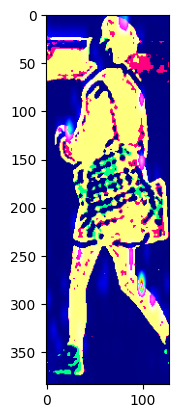

In [92]:
import matplotlib.pyplot as plt
plt.imshow(cv2.resize(np_img, (128, 384)))
plt.imshow(cv2.cvtColor(cv2.resize(mask, (128, 384)), cv2.COLOR_BGR2RGB))

In [71]:
cnn_config = yaml.load(open("./configs/finetune/cuhk_pedes_ckc_mm_mlm.yaml", 'r'), Loader=yaml.Loader)
model_ckc = XVLMForRetrieval(config=cnn_config)

### text_drop_path_rate: 0.0, cross_drop_path_rate: 0.0
### drop path rate:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
### X-VLM, num_text_layers:  12
### X-VLM, num_cross_layers:  6
### text_drop_path_rate: 0.0, cross_drop_path_rate: 0.0
### drop path rate:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
### X-VLM, num_text_layers:  12


In [16]:
model_ckc.load_state_dict(torch.load("./output/tmp/model_80-1.th", map_location="cpu")["model"])

<All keys matched successfully>

In [17]:
grad_rollout_ckc = VITAttentionRollout(model_ckc.vision_encoder, discard_ratio=0.9, head_fusion='max')

In [19]:
mask_ckc = grad_rollout_ckc(img.unsqueeze(0))


In [20]:
mask_ckc = cv2.resize(mask_ckc, (np_img.shape[1], np_img.shape[0]))

mask_ckc = show_mask_on_image(np_img, mask_ckc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


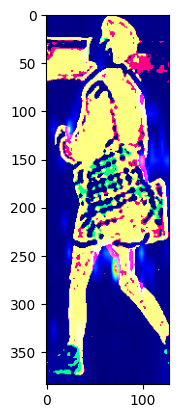

In [22]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(cv2.resize(np_img, (128, 384)), cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(cv2.resize(mask_ckc, (128, 384)), cv2.COLOR_BGR2RGB))